In [4]:
import os
import numpy as np
import pandas as pd
from scipy import stats

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


In [6]:
df = pd.read_csv("throughput_logs.csv")
df.count()

file_name            102895
network_name         102815
p1                   102895
p2                   102895
p3                   102860
p4                   102841
p5                   102808
p6                   102793
p7                   102760
p8                   102727
p9                   102674
p10                  102492
p11                  100247
p12                   99495
p13                   99040
p14                   96829
p15                   94614
p16                   93660
p17                   91847
p18                   88739
mean_throughput      102895
median_throughput    102895
stdv_throughput      102895
p19                   86724
p20                   84687
p21                   82637
p22                   80637
p23                   78730
p24                   76797
p25                   75035
p26                   73444
p27                   71678
p28                   68850
p29                   66945
p30                   65664
dtype: int64

In [7]:
df.network_name.value_counts()

xsede        74261
dtns         19205
esnet         6849
pronghorn     2500
Name: network_name, dtype: int64

In [45]:
data = df[df.network_name=='xsede'][['p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'mean_throughput']]
data.dropna(inplace=True)
data = data[((data>data.quantile(0.1)) & (data<data.quantile(0.9))).all(axis=1)]
data.count()

p2                 36996
p3                 36996
p4                 36996
p5                 36996
p6                 36996
p7                 36996
p8                 36996
p9                 36996
p10                36996
mean_throughput    36996
dtype: int64

## Pairwise Relationships

In [46]:
# sns.pairplot(data[["p2", "p3", "p4", "mean_throughput"]], diag_kind="kde")
# plt.show()

data.corr()

,p2,p3,p4,p5,p6,p7,p8,p9,p10,mean_throughput
p2,1.000000,0.596067,0.534128,0.527828,0.434075,0.282521,0.169782,0.121941,0.094961,0.140764
p3,0.596067,1.000000,0.860290,0.778945,0.642535,0.430532,0.289327,0.215610,0.161146,0.145067
p4,0.534128,0.860290,1.000000,0.837437,0.692513,0.496890,0.349848,0.271036,0.207277,0.185739
p5,0.527828,0.778945,0.837437,1.000000,0.792779,0.592369,0.451483,0.361683,0.298200,0.295206
p6,0.434075,0.642535,0.692513,0.792779,1.000000,0.757656,0.619744,0.524870,0.459247,0.472251
p7,0.282521,0.430532,0.496890,0.592369,0.757656,1.000000,0.787771,0.688084,0.622279,0.629545
p8,0.169782,0.289327,0.349848,0.451483,0.619744,0.787771,1.000000,0.813269,0.746797,0.739491
p9,0.121941,0.215610,0.271036,0.361683,0.524870,0.688084,0.813269,1.000000,0.814580,0.802748
p10,0.094961,0.161146,0.207277,0.298200,0.459247,0.622279,0.746797,0.814580,1.000000,0.835150
mean_throughput,0.140764,0.145067,0.185739,0.295206,0.472251,0.629545,0.739491,0.802748,0.835150,1.000000


## Train and Test Data

In [47]:
train_dataset = data.sample(frac=0.8,random_state=0)
test_dataset = data.drop(train_dataset.index)

In [48]:
train_stats = train_dataset.describe()
train_stats.pop("mean_throughput")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
p2,29597.0,521.918393,326.361914,71.759071,227.016704,481.296384,740.294656,1418.723328
p3,29597.0,1752.002175,959.650746,203.423744,968.884224,1713.373184,2392.850432,5142.216704
p4,29597.0,1766.443026,917.571724,224.395264,1040.187392,1734.344704,2382.364672,4949.278720
p5,29597.0,1900.607399,898.817566,297.795584,1201.668096,1849.688064,2464.153600,4942.987264
p6,29597.0,2126.252579,930.890582,530.579456,1426.063360,2013.265920,2650.800128,5599.395840
p7,29597.0,2406.494781,1071.341315,497.025024,1635.778560,2237.661184,3009.413120,6509.559808
p8,29597.0,2663.873086,1254.515955,595.591168,1744.830464,2378.170368,3254.779904,7648.313344
p9,29597.0,2826.745491,1413.943790,591.396864,1805.647872,2453.667840,3355.443200,8394.899456
p10,29597.0,2967.947939,1543.231353,845.152256,1876.951040,2516.582400,3458.203648,8977.907712


In [49]:
train_labels = train_dataset.pop('mean_throughput')
test_labels = test_dataset.pop('mean_throughput')

## Normalization

In [50]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Model

In [51]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [52]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.figure(figsize=(15,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [mean_throughput]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.figure(figsize=(15,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$mean_throughput^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show();


plot_history(history)

## Training - Early Terminations if Possible

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

## Output

In [41]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error: 442.78


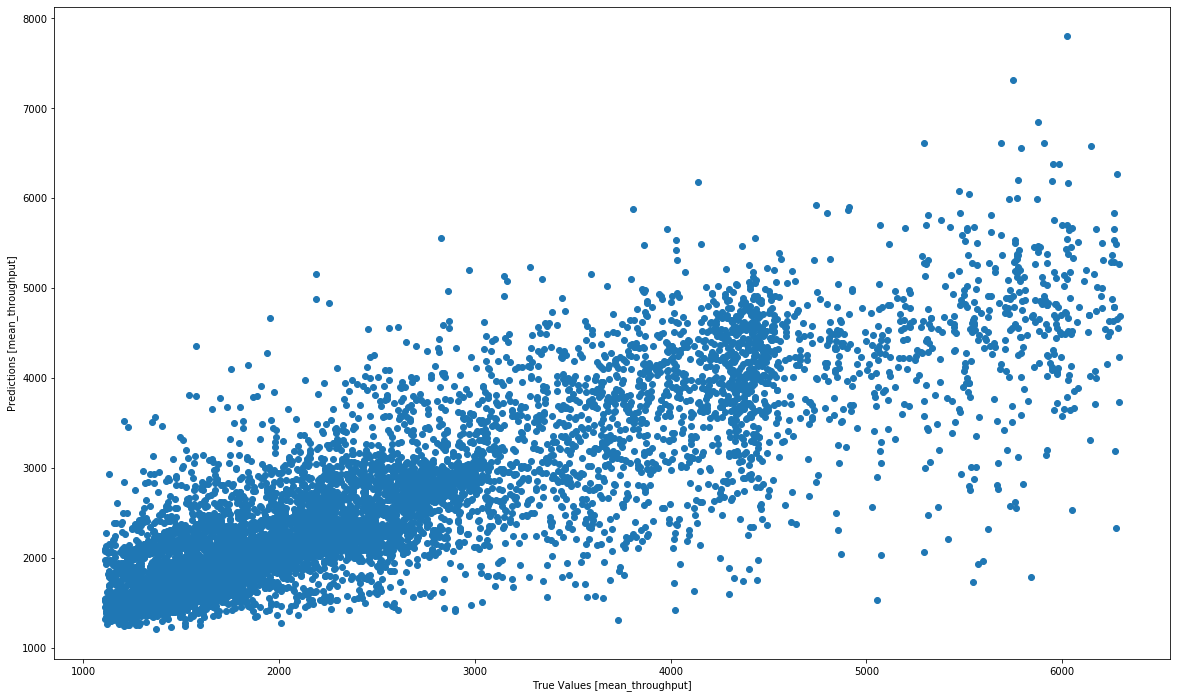

In [42]:
test_predictions = model.predict(normed_test_data).flatten()

plt.figure(figsize=(20,12))
plt.xlabel('True Values [mean_throughput]')
plt.ylabel('Predictions [mean_throughput]')
plt.scatter(test_labels, test_predictions)
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
plt.show()
# _ = plt.plot([0, 0], [-100, 100])

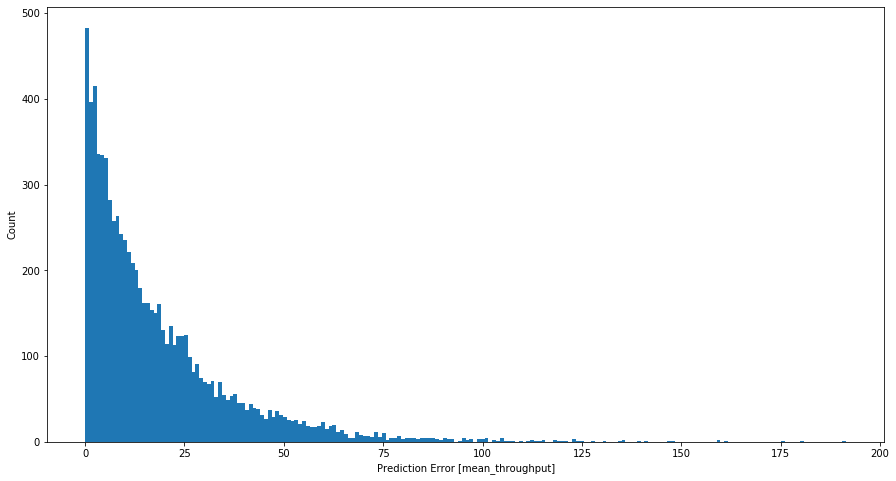

In [43]:
error = np.abs((test_predictions - test_labels)/test_labels) * 100
plt.figure(figsize=(15,8))
plt.hist(error, bins = 200)
plt.xlabel("Prediction Error [mean_throughput]")
_ = plt.ylabel("Count")

#### Error Rate

In [44]:
np.round(np.mean(error), 2)

18.17

#### Error Distribution

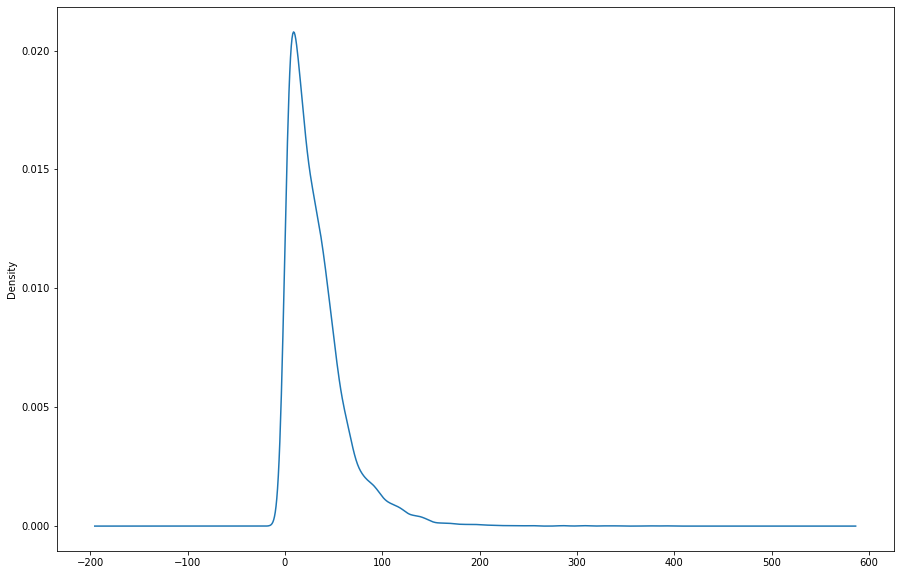

In [27]:
plt.figure(figsize=(15,10))
error.plot.kde();

#### Worst performing Data Points

In [28]:
np.mean(error[error<50])

20.621297409459476

In [29]:
data.loc[error[error>100].index,:]

,p2,p3,p4,mean_throughput
100,809.500672,1207.959552,671.088640,1244.170377
339,706.740224,2086.666240,1063.256064,1118.830592
483,256.551595,1109.393408,1358.954496,1392.811850
552,100.663296,482.344960,652.214272,1175.243981
659,353.020587,1184.890880,1262.485504,1276.559724
747,449.839104,3009.413120,2648.702976,1167.421604
996,471.859200,958.398464,822.083584,1206.305132
1017,159.383552,4445.962240,4062.183424,1959.897017
1420,250.959189,983.564288,1216.348160,1645.716730
1429,550.502400,1075.838976,635.437056,1549.480755
